type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
size of image: (150, 150)


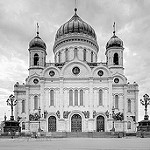

In [5]:
#PIL = Python Imaging Library

import matplotlib.pyplot as plt
from PIL import Image

img = Image.open("./building.jpg")
print("type: {}".format(type(img)))
img=img.convert("L") # PIL로 이미지 불러온담에 그 이미지에 convert("L")하면 흑백으로 변환된다
print("size of image: {}".format(img.size))
img

In [6]:
#이미지를 텐서로 바꿀 땐 numpy 사용 (수치해석용)
import torch
import numpy as np

img_tensor = torch.Tensor(np.array(img))

[[ -5.  -2.  24.]
 [-15.  -9.  17.]
 [-15. -20.  -4.]]


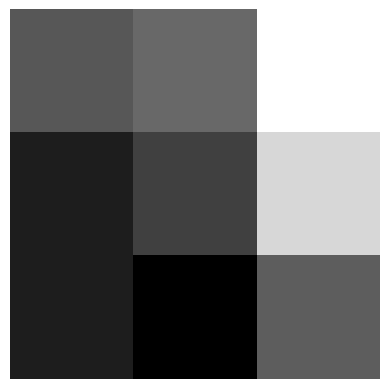

In [7]:
#합성곱
ex_img = np.array([[13, 1, 1, 3, 4],
                   [12, 14, 14, 2, 2],
                   [1, 0, 16, 12, 1],
                   [3, 3, 1, 12, 11],
                   [2, 2, 4, 1, 13]])

ex_img_tensor = torch.Tensor(ex_img) #어짜피 이미지는 픽셀로 이루어진 숫자니깐, 위에서 행렬로 해주고 이제 텐서로 바꿔줌

kernel = torch.Tensor([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

def convolution_operation (x, kernel):
    *_, height, weight = x.size()
    kernel_size = kernel.size(0)
    convs = []
    for i in range(height-kernel_size+1): #뒤에다가 j 조건문을 써줘도 된다
        c = [torch.sum(x[i:(i+kernel_size), j:(j+kernel_size)]*kernel) for j in range(weight-kernel_size+1)] #이미지에서 커널 사이즈와 해당하는 영역과 커널을 곱해줌
        convs.append(c)
    convs = torch.Tensor(convs)
    return convs

convs = convolution_operation(ex_img_tensor, kernel)
print(np.array(convs))

fig, ax = plt.subplots(1,1)
ax.matshow(np.array(convs), cmap="gray")
ax.axis('off')
plt.show()

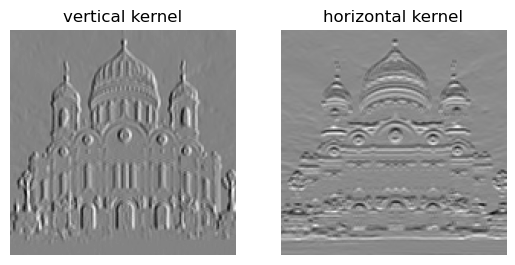

In [9]:
#가운데 열이 0이면 수직 커널, 가운데 행이 0이면 수평커널
vertical_kernel = torch.Tensor([[1,0,-1],
                                [1,0,-1],
                                [1,0,-1]])
vertical_convs = convolution_operation(img_tensor, vertical_kernel)

horizontal_kernel = torch.Tensor([[1,1,1],
                                  [0,0,0],
                                  [-1,-1,-1]])
horizontal_convs = convolution_operation(img_tensor, horizontal_kernel)

fig, (ax1, ax2)= plt.subplots(1,2)
ax1.imshow(vertical_convs.numpy(), cmap='binary')
ax1.axis('off')
ax1.set_title('vertical kernel')
ax2.imshow(horizontal_convs.numpy(), cmap='binary')
ax2.axis('off')
ax2.set_title('horizontal kernel')
plt.show()

Size after convolution operation: torch.Size([1, 1, 148, 148])


(-0.5, 147.5, 147.5, -0.5)

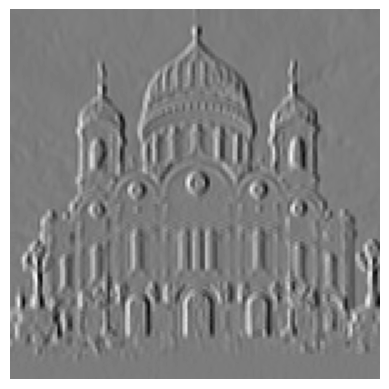

In [16]:
#합성곱 연산 층과 활성화 맵
import torch
import torch.nn as nn

img_tensor = torch.Tensor(np.array(img)).expand(1,1,150,150)
batch, in_channels, height, weight = img_tensor.size()
out_channels = 1
kernel_size = 3
stride = 1

conv_layer = nn.Conv2d(in_channels=in_channels,
                       out_channels=out_channels,
                       kernel_size = kernel_size,
                       stride=stride,
                       bias=False)

conv_layer.weight.data = vertical_kernel.expand(1,1,kernel_size, kernel_size)
convs = conv_layer(img_tensor)

print("Size after convolution operation: {}".format(convs.size()))
plt.imshow(convs.squeeze().detach().numpy(), cmap='gray')
plt.axis('off')

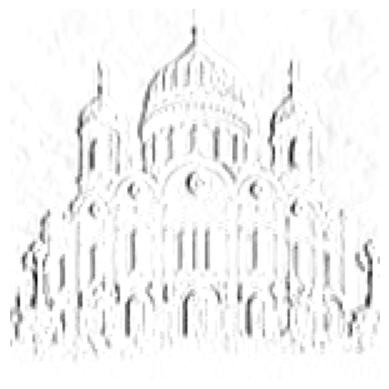

In [18]:
#활성화 함수를 거쳐야 완전한 합성곱 층이 됨
activation_maps = torch.relu(convs)

plt.imshow(activation_maps.squeeze().detach().numpy(), cmap='binary')
plt.axis('off')
plt.show()

In [19]:
# 풀링
def pooling(x, kernel_size, stride=None):
    """Max pooling"""
    assert x.ndimension() ==4, 'only support 4d tensor' #4차원 텐서만 가능
    if stride is None:
        stride = kernel_size
    b, c, height, weight = x.size() #x 구성요소를 각각 배치, 채널, 높이, 너비로 분리해줌
    maxpool = x.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride).max(-1)[0].max(-1)[0] #x.unfold는 슬라이딩 윈도우 생성
    return maxpool

maxpools = pooling(activation_maps, kernel_size=2)

Size after maxpooling operation: torch.Size([1, 1, 74, 74])


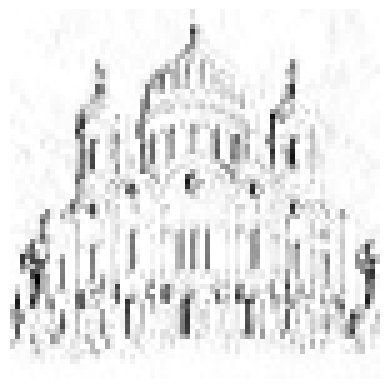

In [20]:
maxpool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
maxpools = maxpool_layer(activation_maps)

print("Size after maxpooling operation: {}".format(maxpools.size()))
plt.imshow(maxpools.squeeze().detach().numpy(), cmap='binary')
plt.axis('off')
plt.show()

### 합성곱 네트워크 만들기: gpu가 부족하여 이하 내용은 구글 코랩으로 작성하였습니다.